In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from tqdm import tqdm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("train.csv")

In [3]:
cm = sns.light_palette("pink", as_cmap=True)
df.head(20).style.background_gradient(cmap=cm)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000000,14115,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,nan,Attchd,1993.000000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,nan,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000000,10084,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,nan,nan,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000000,6120,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,nan,nan,nan,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000000,7420,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,B

 ### Showing the data type for each column in the dataset.

In [4]:
pd.DataFrame(df.dtypes, columns=["type"])

,type
Id,int64
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
...,...
MoSold,int64
YrSold,int64
SaleType,object
SaleCondition,object


### What about a quick statistical look?

In [5]:
df.describe().style.background_gradient(cmap=cm)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Let's see how many null values in each column!

In [6]:
isnull = df.isnull().sum().sort_values(ascending=False).to_frame()
isnull.columns = ['How_many']
isnull['precentage'] = np.around(((isnull / len(df) * 100)[(isnull / len(df) * 100) != 0]), decimals=2)
isnull[isnull.How_many > 0].style.background_gradient(cmap=cm)

,How_many,precentage
PoolQC,1453,99.520000
MiscFeature,1406,96.300000
Alley,1369,93.770000
Fence,1179,80.750000
FireplaceQu,690,47.260000
LotFrontage,259,17.740000
GarageYrBlt,81,5.550000
GarageCond,81,5.550000
GarageType,81,5.550000
GarageFinish,81,5.550000


### Now let's see how the variables correlate with each other!

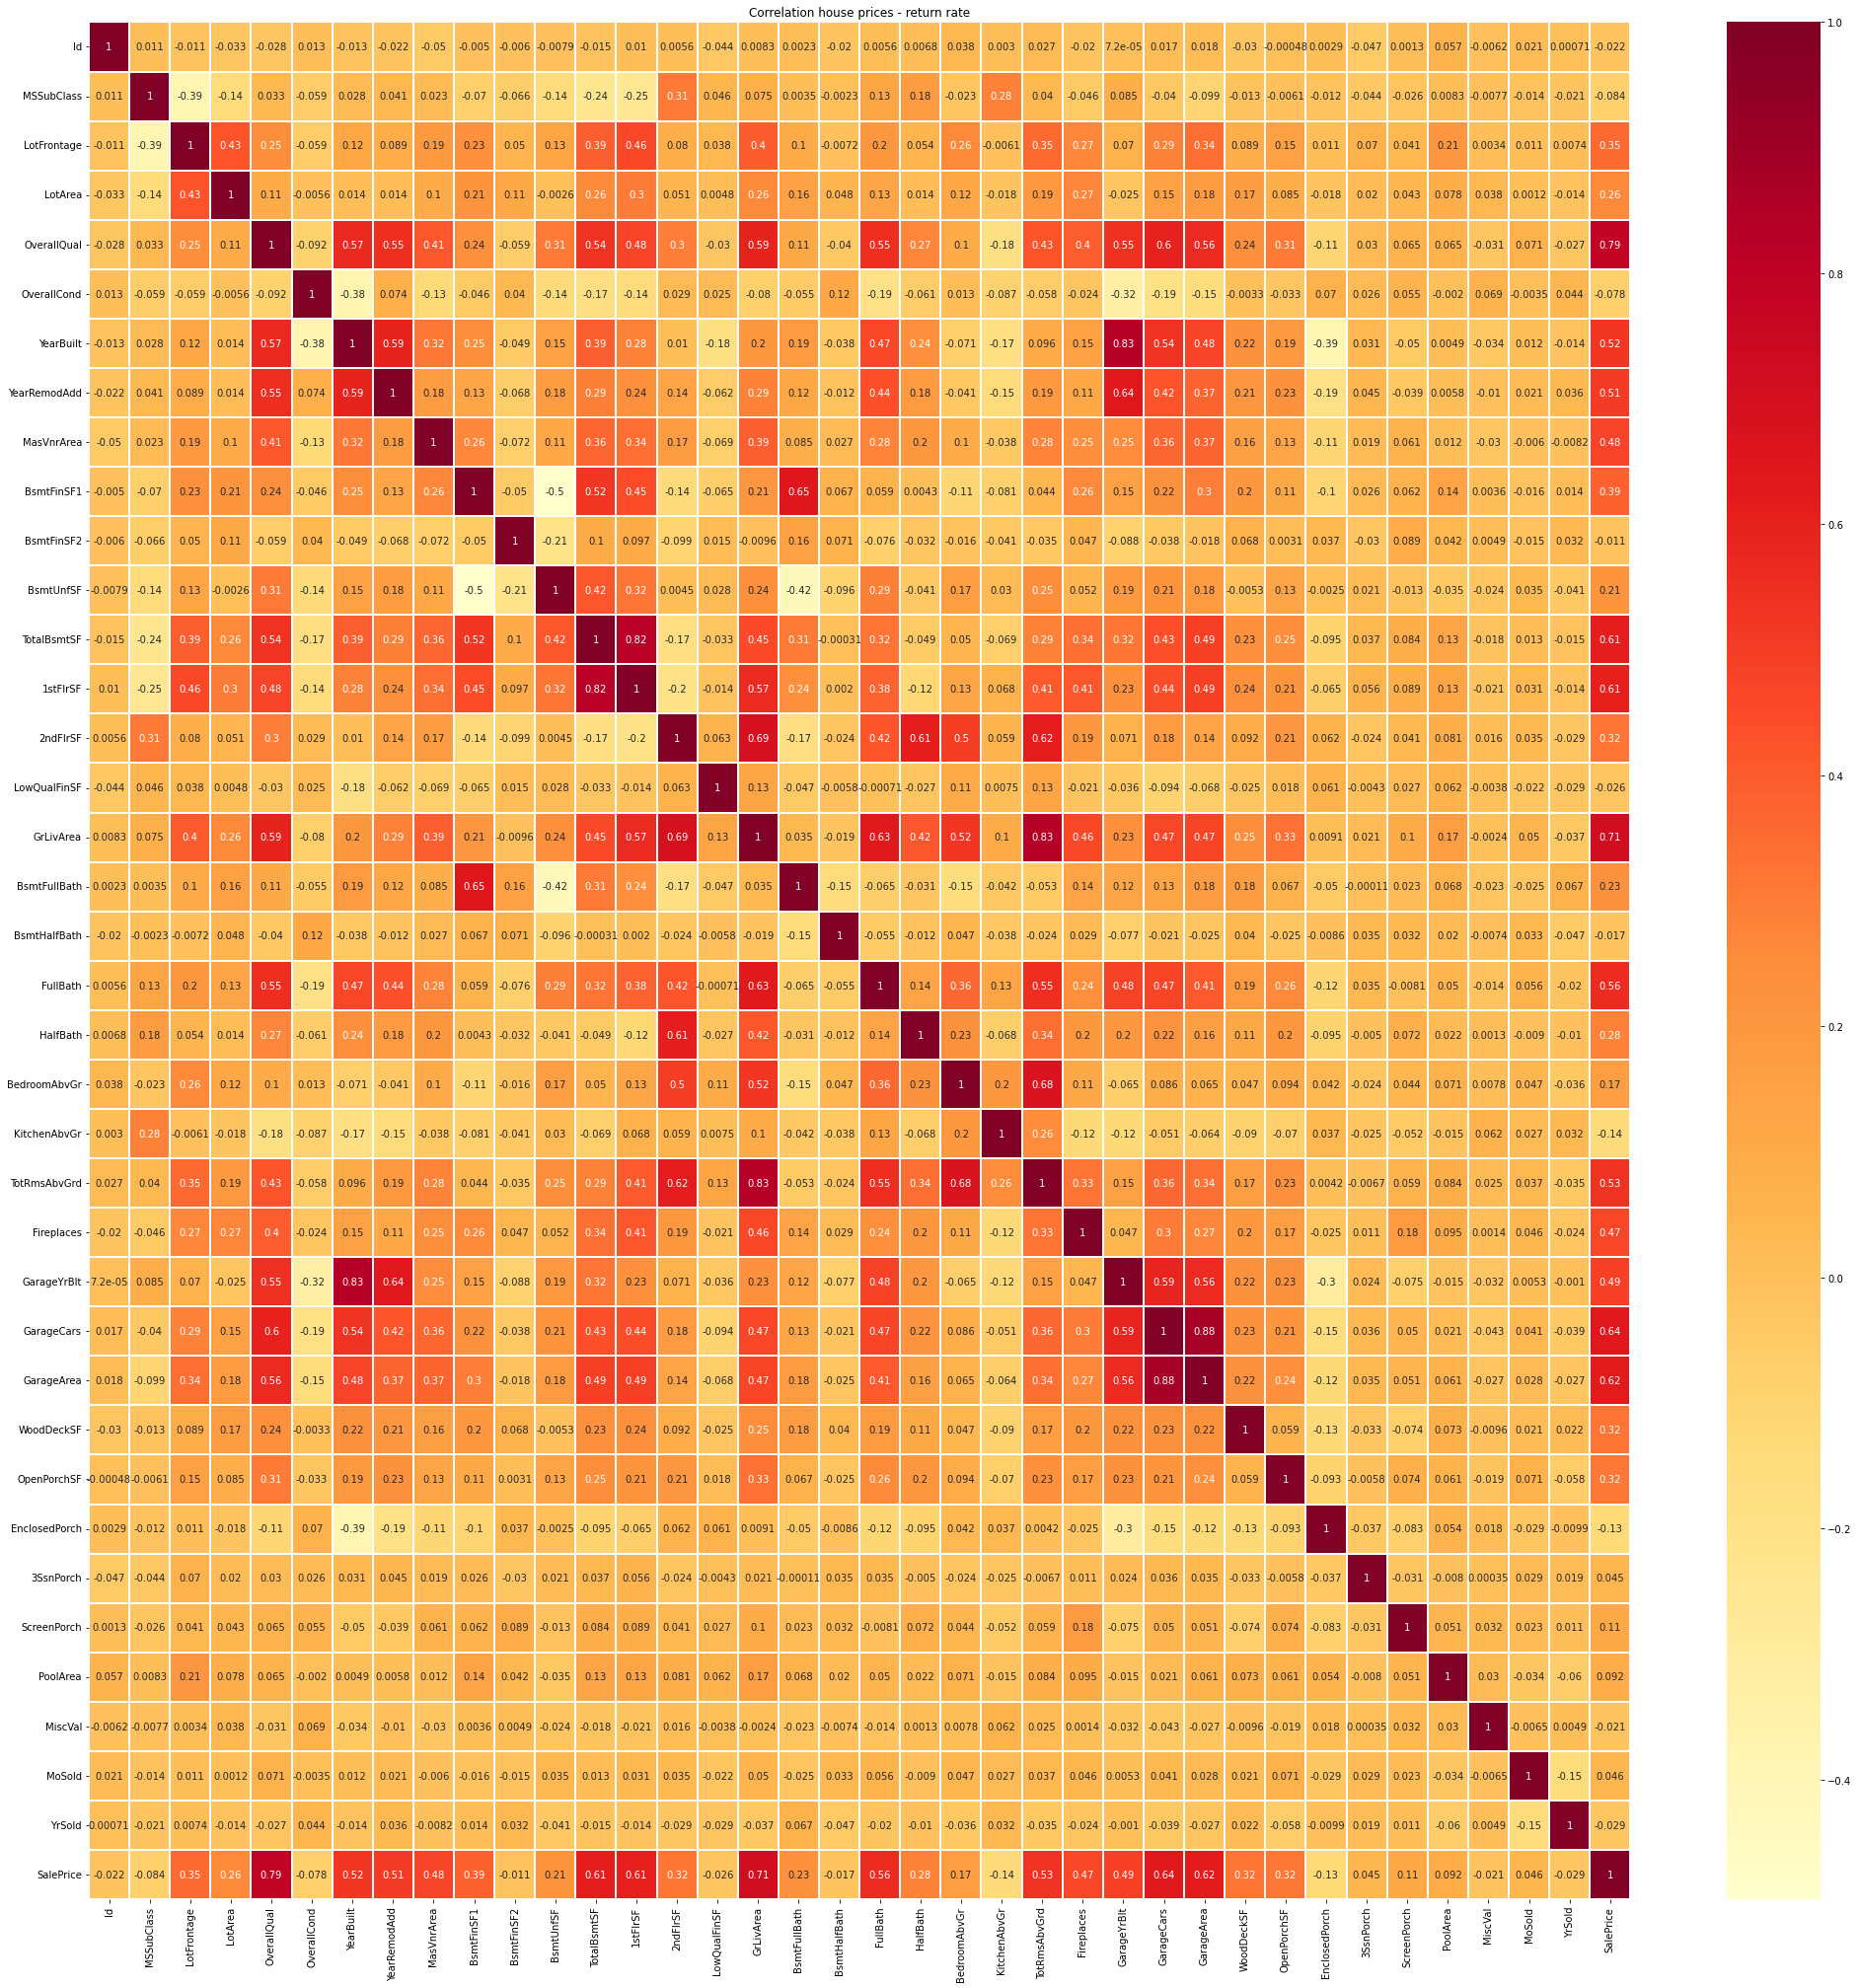

In [7]:
plt.figure(figsize=(35, 35))
sns.heatmap(df.corr(), annot=True, cmap="YlOrRd", linewidths=0.1, annot_kws={"fontsize":10})
plt.title("Correlation house prices - return rate");

In [8]:
correlation = df.corr().unstack().sort_values(kind="quicksort", ascending=False)

correlation = correlation[correlation!=1]
print("-------------------------------------------------------")
print("Top 20 with highest positive correlation")
print("-------------------------------------------------------")
print(correlation[:20])
print("-------------------------------------------------------")
print("Top 20 with highest negative correlation")
print("-------------------------------------------------------")
print(correlation[-20:][::-1])

-------------------------------------------------------
Top 20 with highest positive correlation
-------------------------------------------------------
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
1stFlrSF      TotalBsmtSF     0.819530
TotalBsmtSF   1stFlrSF        0.819530
OverallQual   SalePrice       0.790982
SalePrice     OverallQual     0.790982
              GrLivArea       0.708624
GrLivArea     SalePrice       0.708624
              2ndFlrSF        0.687501
2ndFlrSF      GrLivArea       0.687501
TotRmsAbvGrd  BedroomAbvGr    0.676620
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
BsmtFullBath  BsmtFinSF1      0.649212
GarageYrBlt   YearRemodAdd    0.642277
YearRemodAdd  GarageYrBlt     0.642277
dtype: float64
----------------------------------------------------

### Now let's get to splitting out data into train and validation sets!

In [9]:
df.dropna(axis=0,subset = ['SalePrice'], inplace = True)

In [10]:
df["SalePrice"].isnull().sum()

0

In [11]:
X_train_full = df.drop(['SalePrice'], axis =1)
y_train_full = df.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full,test_size=0.25, random_state=42)

In [12]:
# Geting the names of the categorical columns.
cat_columns = [column for column in X_train.columns if X_train[column].dtype == 'object']
cat_columns

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [13]:
num_columns = [column for column in X_train.columns if X_train[column].dtype != 'object']
num_columns

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [14]:
# A categorical transformer.
cat_trans = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown = 'ignore'))
])

# A numrical transformer.
num_trans = Pipeline(steps = [
    ('imputer',KNNImputer(n_neighbors = 5)),
    ('scaler',StandardScaler())
])

# A preprocessor that combines the two previous transformers.
preprocessor = ColumnTransformer(transformers = [
    ('num', num_trans, num_columns),
    ('cat', cat_trans, cat_columns)
],
    remainder = "drop")

### After creating our preprocessor, let's get it engaged with our data!

In [15]:
preprocessor.fit(X_train)
X_train_trans = preprocessor.fit_transform(X_train).toarray()
X_valid_trans = preprocessor.transform(X_valid).toarray()

### Now it's time for creating models, to accomplish this task I found 4 popular models (algorithms) to do the job, so let's start creating them and then test them to find the best one to solve this task

In [16]:
results = []
results_train = []
possibles_k = np.arange(3,99, 2)

for k in tqdm(possibles_k):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_trans, y_train)
    y_hat = knn.predict(X_valid_trans)
    
    results.append(mean_absolute_error(y_valid, y_hat))
    
    y_hat = knn.predict(X_train_trans)
    results_train.append(mean_absolute_error(y_train, y_hat))
    
    
idx = np.argmin(results)   
print(f"Best k: {possibles_k[idx]}")
print(f"Best RMSE: {results[idx]}")

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.17it/s]

Best k: 9
Best RMSE: 20927.144596651448


In [17]:
knn_model = KNeighborsRegressor(n_neighbors=9)
knn_model.fit(X_train_trans,y_train)
y_pred = knn_model.predict(X_valid_trans)
mean_absolute_error(y_valid, y_pred)

20927.144596651448

In [18]:
r2_score(y_valid, y_pred)


0.8144459203951802